In [3]:
# Importing external libraries
import tensorflow as tf

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [5]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

### Loading the dataset from Tensorflow Datasets

We will be downloading the Flowers daataset from Tensorflow Datasets. Clearly, it is stored as tf_flowers under the Tensorflow Datasets documentation.

From the documentation, it is clear that the dataset in only split in TRAINING SET. Hence, we will be using `tfds.splits` to split the dataset into training and validation set.

We will be performing a 70:30 split i.e., 70% training and 30% validation set.

We will be loading the tf_flowers dataset using tfds.load

We need to make use of  tfds.load function to include all the parameters that we need, and also make sure it returns the dataset info, so we can retrieve information about the datasets.

In [6]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


### Printing Information about Flowers Dataset

In [7]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [8]:
# Checking the shape of flower images
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


### Reformatting Images and Creating Batches

Since, we are training the model using Inception Model, we need to reformat the images to RGB Images with 299 * 299 pixels size.

And then, we will be setting the batch size for training and validation to 32


In [9]:
IMAGE_RES = 299

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

## Performing Simple Transfer Learning using Tensorflow Hub

Note that we're calling the partial model from TensorFlow Hub (without the final classification layer) a feature_extractor. The reasoning for this term is that it will take the input all the way to a layer containing a number of features. So it has done the bulk of the work in identifying the content of an image, except for creating the final probability distribution. That is, it has extracted the features of the image.

In [12]:
URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

### Freezing the Pre-trained Model

In [13]:
feature_extractor.trainable=False

### Attaching the Model Classsification to the hub layers

In [14]:
model_inception = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


### Training the model

Using only EPOCHS= 6

In [16]:
model_inception.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 34s 213ms/step - loss: 0.7664 - accuracy: 0.7213 - val_loss: 0.4632 - val_accuracy: 0.8510
Epoch 2/6
81/81 [==============================] - 13s 164ms/step - loss: 0.4033 - accuracy: 0.8719 - val_loss: 0.3570 - val_accuracy: 0.8847
Epoch 3/6
81/81 [==============================] - 14s 170ms/step - loss: 0.3104 - accuracy: 0.9050 - val_loss: 0.3213 - val_accuracy: 0.8847
Epoch 4/6
81/81 [==============================] - 15s 182ms/step - loss: 0.2708 - accuracy: 0.9198 - val_loss: 0.2978 - val_accuracy: 0.8992
Epoch 5/6
81/81 [==============================] - 14s 170ms/step - loss: 0.2339 - accuracy: 0.9327 - val_loss: 0.2958 - val_accuracy: 0.8928
Epoch 6/6
81/81 [==============================] - 14s 172ms/step - loss: 0.2145 - accuracy: 0.9362 - val_loss: 0.2770 - val_accuracy: 0.9037


### Plotting Training andValidation Graphs



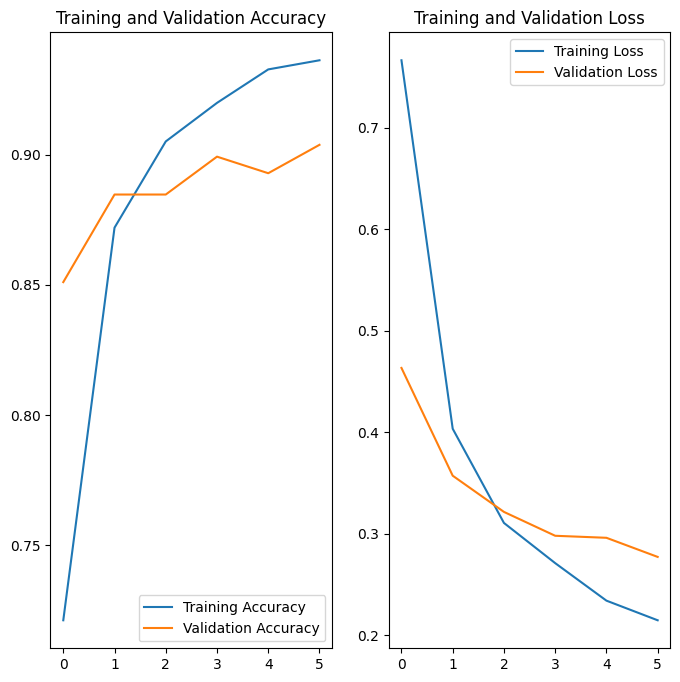

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Checking Predictions

Creating a image batch and checking predictions

In [18]:
class_names = np.array(dataset_info.features['label'].names)

print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [20]:
import numpy as np

image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model_inception.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

1/1 [==============================] - 1s 1s/step
['daisy' 'dandelion' 'tulips' 'daisy' 'tulips' 'sunflowers' 'daisy'
 'roses' 'sunflowers' 'sunflowers' 'tulips' 'dandelion' 'roses'
 'dandelion' 'dandelion' 'sunflowers' 'tulips' 'tulips' 'roses'
 'sunflowers' 'sunflowers' 'dandelion' 'tulips' 'dandelion' 'tulips'
 'sunflowers' 'tulips' 'roses' 'tulips' 'sunflowers' 'daisy' 'dandelion']


In [21]:
# Printing True Labels and Predicted Labels
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model_inception.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

1/1 [==============================] - 0s 66ms/step
['sunflowers' 'dandelion' 'dandelion' 'daisy' 'daisy' 'tulips'
 'sunflowers' 'roses' 'roses' 'sunflowers' 'dandelion' 'dandelion' 'daisy'
 'sunflowers' 'sunflowers' 'tulips' 'daisy' 'tulips' 'tulips' 'dandelion'
 'tulips' 'dandelion' 'roses' 'tulips' 'sunflowers' 'daisy' 'roses'
 'dandelion' 'tulips' 'dandelion' 'sunflowers' 'roses']


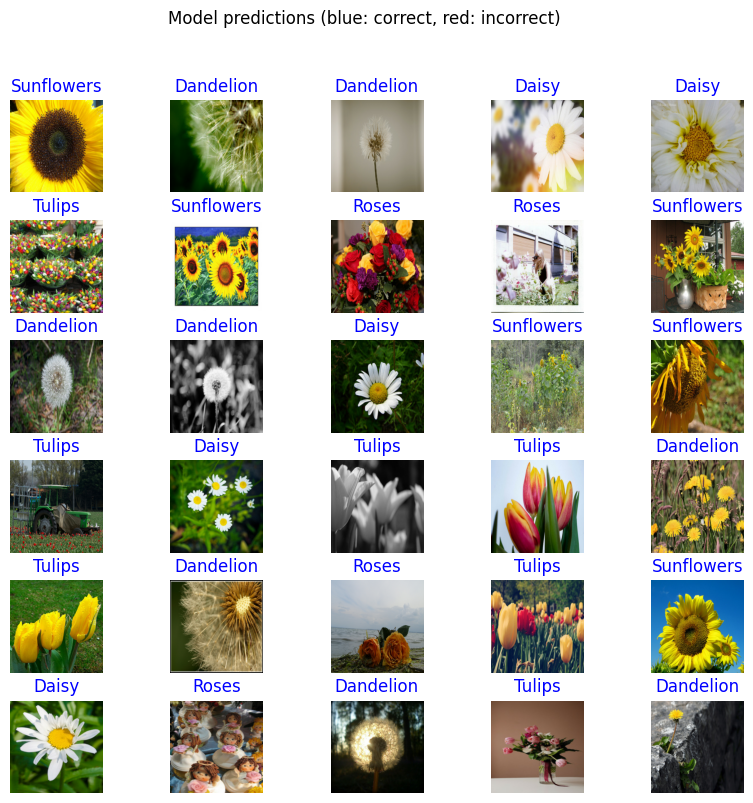

In [22]:
# Plotting Model Predictions

plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")